# End-to-end deep learning - data processing

This notebook does the following:

1. Loads synced data for each participant
2. Performs data processing including window generation, normalisation, condition segmentation
3. Saves data for each modality in seperate files (including one combining all modalities)
4. Plots histogram of data for each modality


Input: 'temp/synced_participant_data/' - individual synced data files for each participant

Output: processed data for  end-to-end ML pipeline per modality 

1. 'segments_all_sensor_dict.pkl.gz'
2. 'segments_emg_amp_dict.pkl.gz'
3. 'segments_emg_contact_dict.pkl.gz'
4. 'segments_hr_dict.pkl.gz'
5. 'segments_imu_dict.pkl.gz'
6. 'segments_eye_dict.pkl.gz'
7. 'segments_rr_dict.pkl.gz'
8. 'segments_gsr_dict.pkl.gz'
9. 'segments_labels_dict.pkl.gz'

* Set working directory to co2-study root folder

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, gc, gzip, pickle, json
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Create temp notebook folder if it does not exist
TEMP_FOLDER = 'temp/6_end_to_end_preprocess_data'
if(not os.path.exists(TEMP_FOLDER)):
    os.mkdir(TEMP_FOLDER)

In [66]:
#prinf libraries versions
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

numpy version:  1.24.4
pandas version:  1.4.4


In [67]:
#read data
INFO_COLUMNS = ['Participant_No', 'Condition', 'Segment','Time']
EMG_AMP_COLUMNS = ['Emg/Amplitude[RightOrbicularis]',
               'Emg/Amplitude[RightZygomaticus]',
               'Emg/Amplitude[RightFrontalis]',
               'Emg/Amplitude[CenterCorrugator]',
               'Emg/Amplitude[LeftFrontalis]',
               'Emg/Amplitude[LeftZygomaticus]',
               'Emg/Amplitude[LeftOrbicularis]']
EMG_CONTACT_COLUMNS = ['Emg/Contact[RightOrbicularis]',
               'Emg/Contact[RightZygomaticus]',
               'Emg/Contact[RightFrontalis]',
               'Emg/Contact[CenterCorrugator]',
               'Emg/Contact[LeftFrontalis]',
               'Emg/Contact[LeftZygomaticus]',
               'Emg/Contact[LeftOrbicularis]']
HR_COLUMNS = ['HeartRate/Average', 'Ppg/Raw.ppg']
IMU_COLUMNS = ['Accelerometer/Raw.x', 'Accelerometer/Raw.y', 'Accelerometer/Raw.z', 
               'Gyroscope/Raw.x', 'Gyroscope/Raw.y', 'Gyroscope/Raw.z']
EYE_COLUMNS = ['VerboseData.Right.PupilDiameterMm','VerboseData.Left.PupilDiameterMm']
BIOPAC_RR_COLUMNS = ['Biopac_RSP']
BIOPAC_GSR_COLUMNS = ['Biopac_GSR']
SENSOR_COLUMNS = EMG_AMP_COLUMNS + EMG_CONTACT_COLUMNS + HR_COLUMNS + IMU_COLUMNS + EYE_COLUMNS + BIOPAC_RR_COLUMNS + BIOPAC_GSR_COLUMNS

ALL_COLUMNS = INFO_COLUMNS + SENSOR_COLUMNS
SAMPLING_RATE = 10 #original sampling is 50, bu later we downsample to 10
data_folder = 'temp/synced_participant_data/'

In [68]:
df_emg_amp = pd.DataFrame()
df_emg_contact = pd.DataFrame()
df_hr = pd.DataFrame()
df_imu = pd.DataFrame()
df_eye = pd.DataFrame()
df_rr = pd.DataFrame()
df_gsr = pd.DataFrame()
df_all_sensor = pd.DataFrame() #all senosr data
df_info = pd.DataFrame() #all info data including labels

for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        df = pd.read_csv(data_folder + file)
        #original sampling is 50, downsample to 10
        df = df.iloc[::5, :]
        df = df[ALL_COLUMNS]
        #dropna
        print('before dropna: ', df.shape)
        df = df.dropna()
        print('after dropna: ', df.shape)

        df_all_sensor = pd.concat([df_all_sensor, df[SENSOR_COLUMNS]])
        df_info = pd.concat([df_info, df[INFO_COLUMNS]])

        df_emg_amp = pd.concat([df_emg_amp, df[EMG_AMP_COLUMNS]])
        df_emg_contact = pd.concat([df_emg_contact, df[EMG_CONTACT_COLUMNS]])
        df_hr = pd.concat([df_hr, df[HR_COLUMNS]])
        df_imu = pd.concat([df_imu, df[IMU_COLUMNS]])
        df_eye = pd.concat([df_eye, df[EYE_COLUMNS]])
        df_rr = pd.concat([df_rr, df[BIOPAC_RR_COLUMNS]])
        df_gsr = pd.concat([df_gsr, df[BIOPAC_GSR_COLUMNS]])

        
        del df
        


before dropna:  (30666, 30)
after dropna:  (24923, 30)
before dropna:  (30509, 30)
after dropna:  (24915, 30)
before dropna:  (29955, 30)
after dropna:  (24924, 30)
before dropna:  (29875, 30)
after dropna:  (24923, 30)
before dropna:  (30094, 30)
after dropna:  (24922, 30)
before dropna:  (30416, 30)
after dropna:  (24924, 30)
before dropna:  (30265, 30)
after dropna:  (24924, 30)
before dropna:  (30098, 30)
after dropna:  (24924, 30)
before dropna:  (29045, 30)
after dropna:  (24922, 30)
before dropna:  (29391, 30)
after dropna:  (24924, 30)
before dropna:  (29893, 30)
after dropna:  (24924, 30)
before dropna:  (30050, 30)
after dropna:  (24923, 30)
before dropna:  (31300, 30)
after dropna:  (24923, 30)
before dropna:  (29078, 30)
after dropna:  (24923, 30)
before dropna:  (29943, 30)
after dropna:  (24921, 30)
before dropna:  (29311, 30)
after dropna:  (24923, 30)
before dropna:  (30697, 30)
after dropna:  (24924, 30)
before dropna:  (30901, 30)
after dropna:  (24923, 30)
before dro

In [69]:
df_all_sensor = df_all_sensor.reset_index(drop=True)
df_info = df_info.reset_index(drop=True)

df_emg_amp = df_emg_amp.reset_index(drop=True)
df_emg_contact = df_emg_contact.reset_index(drop=True)
df_hr = df_hr.reset_index(drop=True)
df_imu = df_imu.reset_index(drop=True)
df_eye = df_eye.reset_index(drop=True)
df_rr = df_rr.reset_index(drop=True)
df_gsr = df_gsr.reset_index(drop=True)

df_all_sensor.shape, df_info.shape, df_emg_amp.shape, df_emg_contact.shape, df_hr.shape, df_imu.shape, df_eye.shape, df_rr.shape, df_gsr.shape

((1129903, 26),
 (1129903, 4),
 (1129903, 7),
 (1129903, 7),
 (1129903, 2),
 (1129903, 6),
 (1129903, 2),
 (1129903, 1),
 (1129903, 1))

In [73]:
#print(df_all_sensor.isnull().sum())
df_all_sensor.describe().T

,count,mean,std,min,25%,50%,75%,max
Emg/Amplitude[RightOrbicularis],1129903.0,0.000003,0.000004,7.549922e-07,0.000002,0.000002,0.000003,0.000289
Emg/Amplitude[RightZygomaticus],1129903.0,0.000003,0.000004,0.000000e+00,0.000002,0.000002,0.000003,0.000210
Emg/Amplitude[RightFrontalis],1129903.0,0.000005,0.000004,1.192093e-06,0.000002,0.000003,0.000006,0.000220
Emg/Amplitude[CenterCorrugator],1129903.0,0.000003,0.000003,9.934107e-07,0.000002,0.000002,0.000003,0.000807
Emg/Amplitude[LeftFrontalis],1129903.0,0.000005,0.000005,1.033147e-06,0.000002,0.000004,0.000006,0.000724
Emg/Amplitude[LeftZygomaticus],1129903.0,0.000003,0.000004,8.344650e-07,0.000002,0.000002,0.000004,0.000215
Emg/Amplitude[LeftOrbicularis],1129903.0,0.000003,0.000005,7.947286e-07,0.000002,0.000003,0.000004,0.000333
Emg/Contact[RightOrbicularis],1129903.0,9148.259313,1723.287572,5.872000e+03,8092.000000,8762.000000,9624.000000,21764.000000
Emg/Contact[RightZygomaticus],1129903.0,6581.011625,7665.388839,0.000000e+00,5208.000000,6018.000000,6904.000000,131070.000000
Emg/Contact[RightFrontalis],1129903.0,8297.253019,2479.168878,4.044000e+03,6652.000000,7938.000000,9480.000000,70384.000000


In [75]:
#scale data using 99th percentile as max and 1st percentile as min. remove values outside this range
def scale_data(df):
    df = df.clip(lower=df.quantile(0.01), upper=df.quantile(0.99), axis=1)
    df = (df - df.min()) / (df.max() - df.min())
    return df

df_all_sensor = scale_data(df_all_sensor)
df_emg_amp = scale_data(df_emg_amp)
df_emg_contact = scale_data(df_emg_contact)
df_hr = scale_data(df_hr)
df_imu = scale_data(df_imu)
df_eye = scale_data(df_eye)
df_rr = scale_data(df_rr)
df_gsr = scale_data(df_gsr)

df_all_sensor.describe().T

,count,mean,std,min,25%,50%,75%,max
Emg/Amplitude[RightOrbicularis],1129903.0,0.116625,0.156825,0.0,0.031785,0.063570,0.129584,1.0
Emg/Amplitude[RightZygomaticus],1129903.0,0.140629,0.159977,0.0,0.043478,0.090062,0.173913,1.0
Emg/Amplitude[RightFrontalis],1129903.0,0.179863,0.186521,0.0,0.045802,0.111959,0.254453,1.0
Emg/Amplitude[CenterCorrugator],1129903.0,0.143155,0.161140,0.0,0.044280,0.088561,0.184502,1.0
Emg/Amplitude[LeftFrontalis],1129903.0,0.170206,0.172686,0.0,0.043668,0.115721,0.246725,1.0
Emg/Amplitude[LeftZygomaticus],1129903.0,0.158785,0.170931,0.0,0.047945,0.095890,0.215753,1.0
Emg/Amplitude[LeftOrbicularis],1129903.0,0.127356,0.151950,0.0,0.038560,0.079692,0.159383,1.0
Emg/Contact[RightOrbicularis],1129903.0,0.335046,0.185574,0.0,0.218785,0.293345,0.389272,1.0
Emg/Contact[RightZygomaticus],1129903.0,0.412591,0.212199,0.0,0.254115,0.393004,0.544925,1.0
Emg/Contact[RightFrontalis],1129903.0,0.220565,0.157650,0.0,0.115242,0.197667,0.296500,1.0


In [ ]:
df_info.Condition.value_counts().plot(kind='bar')
plt.title('Number of samples per condition')
plt.show()

plt.figure(figsize=(20, 5))
df_info.Participant_No.value_counts().plot(kind='bar')
plt.title('Number of samples per participant')
plt.show()

In [ ]:
#sliding window segmentation
WINDOW_SIZE_SECONDS = 30
WINDOW_SIZE = WINDOW_SIZE_SECONDS * SAMPLING_RATE
STEP_SIZE = (WINDOW_SIZE_SECONDS//6) * SAMPLING_RATE #get prediction every 5 seconds
#perform segmentation for each user and each condition
segments_all_sensor_dict = {}
segments_emg_amp_dict = {}
segments_emg_contact_dict = {}
segments_hr_dict = {}
segments_imu_dict = {}
segments_eye_dict = {}
segments_rr_dict = {}
segments_gsr_dict = {}
segments_labels_dict = {}

for user in df_info.Participant_No.unique():
    user_segments_all_sensor = []
    user_segments_emg_amp_sensor = []
    user_segments_emg_contact_sensor = []
    user_segments_hr_sensor = []
    user_segments_imu_sensor = []
    user_segments_eye_sensor = []
    user_segments_rr_sensor = []
    user_segments_gsr_sensor = []
    user_labels = []
    for condition in df_info.Condition.unique():
        user_cond_all_sensor_df = df_all_sensor[(df_info.Participant_No == user) & (df_info.Condition == condition)]
        user_cond_emg_amp_df = user_cond_all_sensor_df[EMG_AMP_COLUMNS]
        user_cond_emg_contact_df = user_cond_all_sensor_df[EMG_CONTACT_COLUMNS]
        user_cond_hr_df = user_cond_all_sensor_df[HR_COLUMNS]
        user_cond_imu_df = user_cond_all_sensor_df[IMU_COLUMNS]
        user_cond_eye_df = user_cond_all_sensor_df[EYE_COLUMNS]
        user_cond_rr_df = user_cond_all_sensor_df[BIOPAC_RR_COLUMNS]
        user_cond_gsr_df = user_cond_all_sensor_df[BIOPAC_GSR_COLUMNS]
        user_cond_info_df = df_info[(df_info.Participant_No == user) & (df_info.Condition == condition)]
        
        for i in range(0, len(user_cond_all_sensor_df) - WINDOW_SIZE, STEP_SIZE):
            user_segments_all_sensor.append(user_cond_all_sensor_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_emg_amp_sensor.append(user_cond_emg_amp_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_emg_contact_sensor.append(user_cond_emg_contact_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_hr_sensor.append(user_cond_hr_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_imu_sensor.append(user_cond_imu_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_eye_sensor.append(user_cond_eye_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_rr_sensor.append(user_cond_rr_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_segments_gsr_sensor.append(user_cond_gsr_df.iloc[i:i+WINDOW_SIZE, :].values)
            user_labels.append(user_cond_info_df.Condition.iloc[i:i+WINDOW_SIZE].values)
            
    segments_all_sensor_dict[user] = user_segments_all_sensor
    
    segments_emg_amp_dict[user] = user_segments_emg_amp_sensor
    segments_emg_contact_dict[user] = user_segments_emg_contact_sensor
    segments_hr_dict[user] = user_segments_hr_sensor
    segments_imu_dict[user] = user_segments_imu_sensor
    segments_eye_dict[user] = user_segments_eye_sensor
    segments_rr_dict[user] = user_segments_rr_sensor
    segments_gsr_dict[user] = user_segments_gsr_sensor
    
    segments_labels_dict[user] = user_labels
    #print segments and labels shape
    print('user {} segments shape: '.format(user), np.array(user_segments_all_sensor).shape)
    print('user {} labels shape: '.format(user), np.array(user_labels).shape)
    print()

del df_all_sensor, df_info


In [78]:
#get a list of all users
users = list(segments_all_sensor_dict.keys())
print(len(users))
   

46


In [80]:
#save segments and labels
with gzip.open(os.path.join(TEMP_FOLDER, 'segments_all_sensor_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_all_sensor_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_emg_amp_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_emg_amp_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_emg_contact_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_emg_contact_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_hr_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_hr_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_imu_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_imu_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_eye_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_eye_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_rr_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_rr_dict , f)

with gzip.open(os.path.join(TEMP_FOLDER, 'segments_gsr_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_gsr_dict , f)
    
with gzip.open(os.path.join(TEMP_FOLDER, 'segments_labels_dict.pkl.gz'), 'wb') as f:
    pickle.dump(segments_labels_dict, f)

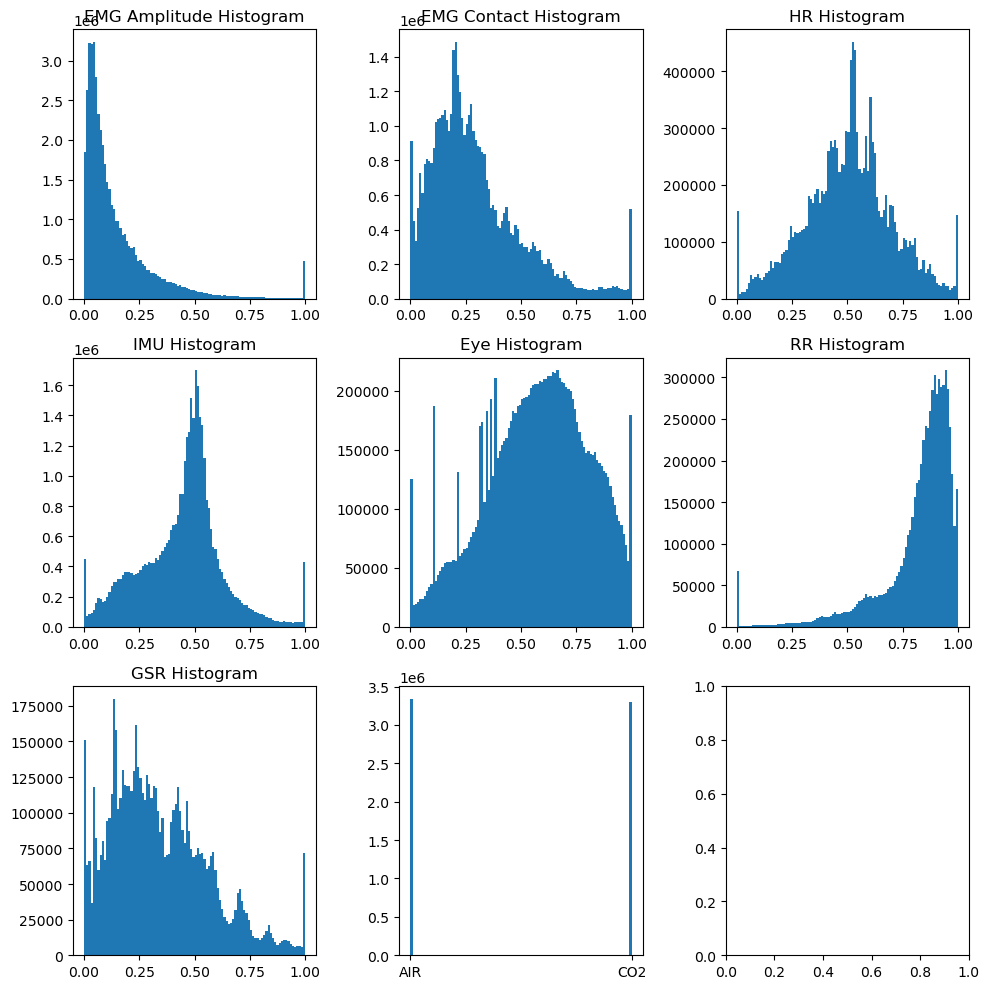

In [81]:
#plot value distribution histogram for each sensor for all users
#combine the plots into one
#use a grid of 3 x 3

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
#flatten the sensor dict
segments_emg_amp_flat = [item for sublist in list(segments_emg_amp_dict.values()) for item in sublist]
segments_emg_contact_flat = [item for sublist in list(segments_emg_contact_dict.values()) for item in sublist]
segments_hr_flat = [item for sublist in list(segments_hr_dict.values()) for item in sublist]
segments_imu_flat = [item for sublist in list(segments_imu_dict.values()) for item in sublist]
segments_eye_flat = [item for sublist in list(segments_eye_dict.values()) for item in sublist]
segments_rr_flat = [item for sublist in list(segments_rr_dict.values()) for item in sublist]
segments_gsr_flat = [item for sublist in list(segments_gsr_dict.values()) for item in sublist]
segments_labels_flat = [item for sublist in list(segments_labels_dict.values()) for item in sublist]

axs[0, 0].hist(np.array(segments_emg_amp_flat).flatten(), bins=100)
axs[0, 0].set_title('EMG Amplitude Histogram')
axs[0, 1].hist(np.array(segments_emg_contact_flat).flatten(), bins=100)
axs[0, 1].set_title('EMG Contact Histogram')
axs[0, 2].hist(np.array(segments_hr_flat).flatten(), bins=100)
axs[0, 2].set_title('HR Histogram')
axs[1, 0].hist(np.array(segments_imu_flat).flatten(), bins=100)
axs[1, 0].set_title('IMU Histogram')
axs[1, 1].hist(np.array(segments_eye_flat).flatten(), bins=100)
axs[1, 1].set_title('Eye Histogram')
axs[1, 2].hist(np.array(segments_rr_flat).flatten(), bins=100)
axs[1, 2].set_title('RR Histogram')
axs[2, 0].hist(np.array(segments_gsr_flat).flatten(), bins=100)
axs[2, 0].set_title('GSR Histogram')
#plot also labels
axs[2, 1].hist(np.array(segments_labels_flat).flatten(), bins=100)

plt.tight_layout()
plt.show()